In [6]:
#data essentials
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

#self created tools
from getting_data import *
from Indicators import *
from y_engineering import *
from metric import *
from models import *

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#sklearn
from sklearn.metrics import *

#visualisation with tensorboard
from torch.utils.tensorboard import SummaryWriter

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
#use gpu if available
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = "cuda"

In [8]:
# obtaining data
df = pd.read_csv("appl_clean_train.csv")

In [9]:
# addig some features
df['y_binary_sma5'] = (sma(df, period=5, column='Adj Close').shift(periods=-5) > df['Adj Close']).astype(int)
ema(df, period=21, column='Adj Close', inplace=True)
ema(df, period=200, column='Adj Close', inplace=True)
df["ema_pct_21"] = pct_log(df, y_col='ema_21', time_to_pred = 1, pct=True, log=False)
df["ema_pct_200"] = pct_log(df, y_col='ema_200', time_to_pred = 1, pct=True, log=False)

In [10]:
rsi(df, period=20, column='Adj Close', ema=True, inplace=True)

1             NaN
2             NaN
3             NaN
4             NaN
5             NaN
          ...    
4996    71.013581
4997    67.657606
4998    70.188659
4999    69.240661
5000    64.442493
Name: Adj Close, Length: 5000, dtype: float64

In [11]:
df

,Adj Close,Volume,pct_log,pct,y_binary_sma5,ema_21,ema_200,ema_pct_21,ema_pct_200,rsi_20
0,0.789849,459177600,NaN,NaN,1,0.789849,0.789849,NaN,NaN,NaN
1,0.809797,597643200,-0.105724,0.025255,1,0.800298,0.799873,0.013229,0.012691,NaN
2,0.862517,1831132800,-0.298956,0.065103,0,0.823043,0.820963,0.028420,0.026367,NaN
3,0.845894,495924800,0.131580,-0.019273,0,0.829596,0.827290,0.007963,0.007706,NaN
4,0.807423,440876800,0.278119,-0.045480,1,0.824279,0.823237,-0.006410,-0.004899,NaN
...,...,...,...,...,...,...,...,...,...,...
4996,65.139717,84020400,0.004179,0.017534,0,63.019752,52.204988,0.003375,0.002496,71.013581
4997,64.631065,105207600,-0.001877,-0.007809,0,63.166235,52.328630,0.002324,0.002368,67.657606
4998,65.499199,65235600,0.003201,0.013432,0,63.378322,52.459681,0.003358,0.002504,70.188659
4999,65.354912,46617600,-0.000527,-0.002203,0,63.558012,52.587992,0.002835,0.002446,69.240661


In [53]:
df["rsi_20"] = (df["rsi_20"]-50)/100

(array([  70.,  232.,  557.,  892., 1084.,  962.,  707.,  327.,  115.,
          35.]),
 array([-0.25805781, -0.19319231, -0.12832681, -0.0634613 ,  0.0014042 ,
         0.0662697 ,  0.1311352 ,  0.1960007 ,  0.2608662 ,  0.32573171,
         0.39059721]),
 <BarContainer object of 10 artists>)

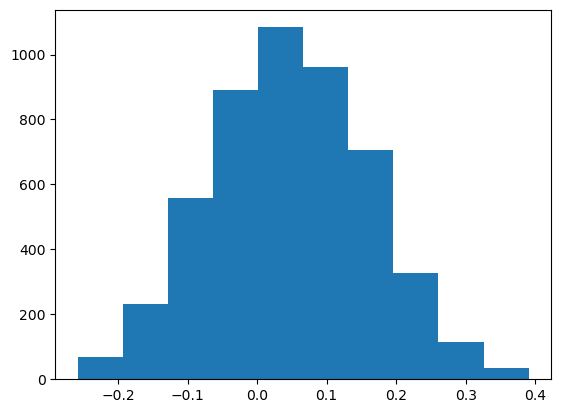

In [54]:
plt.hist(df["rsi_20"])

In [55]:
# get all training and validation data and convert them to gpu

def convert_to_tensor(x):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return [torch.tensor(i).to(device).type(torch.cuda.FloatTensor) for i in x]

temp = get_xy(df, 14, x_col = ["pct"], y_col='y_binary_sma5', val_pct=0.2, period_to_skip=40)
x_train, y_train, x_val, y_val = convert_to_tensor(temp)

ind = get_xy(df, 14, x_col = ['ema_pct_21',"ema_pct_200", "rsi_20"], y_col='y_binary_sma5', val_pct=0.2, period_to_skip=40)
ind_train, _, ind_val, _ = convert_to_tensor(ind)

In [56]:
x_train.shape, ind_train.shape, y_train.shape

(torch.Size([3960, 1, 14]), torch.Size([3960, 3, 14]), torch.Size([3960, 1]))

In [57]:
#turning data into a dataloader

batch_size = 64
x_train_ds = CustomDataset([x_train, ind_train], y_train)
x_val_ds = CustomDataset([x_val, ind_val], y_val)
train_dataloader = DataLoader(x_train_ds, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
val_dataloader = DataLoader(x_val_ds, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))

In [58]:
x_train_ds.Xs[1].size()

torch.Size([3960, 3, 14])

In [59]:
# some debugging to check where the nan values are
for i in range(3969):
    if x_train_ds.Xs[1][i:,:,:].isnan().sum()> 0:
        print(i)
        print(x_train_ds.Xs[1][i:,:,:])

In [60]:
#checking data shapes

temp = next(iter(train_dataloader))
len(temp), temp[0].shape, temp[1].shape, temp[2].shape

(3, torch.Size([64, 1, 14]), torch.Size([64, 3, 14]), torch.Size([64, 1]))

In [61]:
class indicator_cnn(nn.Module):
    """
    basic indicator model with 2 seperate cnn that that takes price and some indicators as input respectively. They both branch into a few common fully connected layers
    
    """
    
    
    def __init__(self):
        super(indicator_cnn, self).__init__()
        
        # direct price input layers
        # self.x_padding = nn.ConstantPad1d((0,2), 0)# we only want to pad the right because the earlier data is not as important
        self.x_conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=3, stride=2)
        self.x_conv2 = nn.Conv1d(6, 12, 2, 1)
        self.x_conv3 = nn.Conv1d(12, 20, 1)
        
        # indicators input layers
        # self.ind_padding = nn.ConstantPad1d((0,2), 0) # we only want to pad the right because the earlier data is not as important
        self.ind_conv1 = nn.Conv1d(in_channels=3, out_channels=6, kernel_size=3, stride=3)
        self.ind_conv2 = nn.Conv1d(6, 12, 1, 1)
        # self.ind_conv3 = nn.Conv1d(10, 16, 1, 1)
        
        #combined layers
        self.fc1 = nn.LazyLinear(40)
        self.fc2 = nn.Linear(40, 20)
        self.fc3 = nn.Linear(20, 1)
    
    def forward(self, x, ind):

        # x = self.x_padding(x)
        x = F.relu(self.x_conv1(x))
        x = F.relu(self.x_conv2(x))
        x = F.relu(self.x_conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        
        # ind = self.ind_padding(ind)
        ind = F.relu(self.ind_conv1(ind))
        ind = F.relu(self.ind_conv2(ind))
        # ind = F.relu(self.ind_conv3(ind))
        ind = ind.view(-1, self.num_flat_features(ind))
        
        combined = torch.cat((x, ind),1)
        combined = F.relu(self.fc1(combined))
        combined = F.relu(self.fc2(combined))
        combined = self.fc3(combined)
        
        return combined
    
    def predict(self, X, return_logits=True, threshold = 0.5):
        logits = torch.sigmoid(self.forward(*X).cpu().detach())
        if return_logits:
            return logits.numpy()
        return (logits > threshold).astype("int")
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def count_parameters(self):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    

model = indicator_cnn().cuda()

/home/jack/anaconda3/envs/trading_environment/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [62]:
#dry run to initialise lazy modules
model(*next(iter(train_dataloader))[:-1])

tensor([[-0.1068],
        [-0.1065],
        [-0.1059],
        [-0.1076],
        [-0.1063],
        [-0.1079],
        [-0.1085],
        [-0.1076],
        [-0.1082],
        [-0.1079],
        [-0.1068],
        [-0.1086],
        [-0.1078],
        [-0.1081],
        [-0.1071],
        [-0.1061],
        [-0.1083],
        [-0.1066],
        [-0.1067],
        [-0.1082],
        [-0.1072],
        [-0.1068],
        [-0.1072],
        [-0.1069],
        [-0.1068],
        [-0.1063],
        [-0.1063],
        [-0.1071],
        [-0.1081],
        [-0.1067],
        [-0.1079],
        [-0.1080],
        [-0.1076],
        [-0.1083],
        [-0.1067],
        [-0.1070],
        [-0.1056],
        [-0.1088],
        [-0.1083],
        [-0.1060],
        [-0.1062],
        [-0.1067],
        [-0.1058],
        [-0.1084],
        [-0.1064],
        [-0.1091],
        [-0.1071],
        [-0.1064],
        [-0.1073],
        [-0.1058],
        [-0.1085],
        [-0.1059],
        [-0.

In [63]:
len(next(iter(train_dataloader))[:-1])

2

In [64]:
model.count_parameters()

7385

In [65]:
print(model)

indicator_cnn(
  (x_conv1): Conv1d(1, 6, kernel_size=(3,), stride=(2,))
  (x_conv2): Conv1d(6, 12, kernel_size=(2,), stride=(1,))
  (x_conv3): Conv1d(12, 20, kernel_size=(1,), stride=(1,))
  (ind_conv1): Conv1d(3, 6, kernel_size=(3,), stride=(3,))
  (ind_conv2): Conv1d(6, 12, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=148, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)


In [66]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas = (0.9, 0.999))
# optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)

In [67]:
# using tensorboard visualisation tool
# To view, start TensorBoard on the command line with:
#tensorboard --logdir=runs
#and open a browser tab to http://localhost:6006/
from datetime import datetime

writer = SummaryWriter('runs/indicator_cnn')
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

In [68]:
# debugging each individual layers
def printnorm(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print('Inside ' + self.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    print('how many nan value:', torch.sum(torch.isnan(output.data)))

In [69]:
# register hooks to look at outputs for debugging

# model.x_conv3.register_forward_hook(printnorm)
# model.ind_conv2.register_forward_hook(printnorm)
# model.fc1.register_forward_hook(printnorm)

In [70]:
#model(*next(iter(train_dataloader))[:-1])

In [71]:
#training
epochs = 40

for t in range(epochs):
    print(f"Epoch {t+1} ------------------------>  ", end='')
    avg_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    avg_vloss, correct = test_loop(val_dataloader, model, loss_fn, batch_size=64)
    
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    t + 1)
    writer.flush()
print("Done!")

Epoch 1 ------------------------>  Avg training loss: 0.010820, Avg val loss: 0.010872, Validation accuracy: 59.5% 

Epoch 2 ------------------------>  Avg training loss: 0.010778, Avg val loss: 0.010866, Validation accuracy: 59.5% 

Epoch 3 ------------------------>  Avg training loss: 0.010778, Avg val loss: 0.010854, Validation accuracy: 59.5% 

Epoch 4 ------------------------>  Avg training loss: 0.010776, Avg val loss: 0.010909, Validation accuracy: 59.5% 

Epoch 5 ------------------------>  Avg training loss: 0.010773, Avg val loss: 0.010841, Validation accuracy: 59.5% 

Epoch 6 ------------------------>  Avg training loss: 0.010780, Avg val loss: 0.010833, Validation accuracy: 59.5% 

Epoch 7 ------------------------>  Avg training loss: 0.010774, Avg val loss: 0.010848, Validation accuracy: 59.5% 

Epoch 8 ------------------------>  Avg training loss: 0.010777, Avg val loss: 0.010850, Validation accuracy: 59.5% 

Epoch 9 ------------------------>  Avg training loss: 0.010772, 

In [82]:
logits = model.predict((x_val, ind_val))
metric = anlayse_binary(logits, y_val.cpu().detach().numpy().astype("int"))

(array([  5., 108.,  93.,  99., 129., 245., 179.,  93.,  28.,  22.]),
 array([0.49711248, 0.50972509, 0.52233773, 0.53495038, 0.54756302,
        0.56017566, 0.5727883 , 0.58540088, 0.59801352, 0.61062616,
        0.6232388 ]),
 <BarContainer object of 10 artists>)

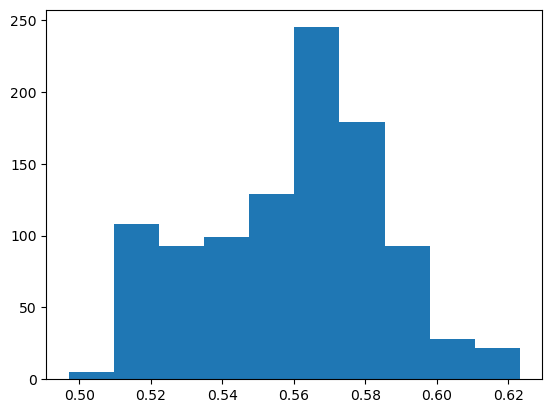

In [83]:
plt.hist(logits)

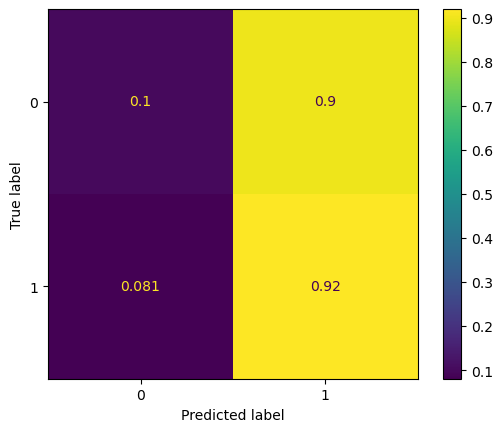

              precision    recall  f1-score   support

           0       0.46      0.10      0.17       405
           1       0.60      0.92      0.73       596

    accuracy                           0.59      1001
   macro avg       0.53      0.51      0.45      1001
weighted avg       0.54      0.59      0.50      1001



In [84]:
metric.binarise(0.52)
metric.show_cf()

In [85]:
metric.threshold_range()

{'precision': [0.596,
  0.5953815261044176,
  0.6008771929824561,
  0.5980861244019139,
  0.5981794538361509,
  0.6077265973254086,
  0.5992970123022847,
  0.5848563968668408,
  0.5969387755102041,
  0.625],
 'recall': [1.0,
  0.9949664429530202,
  0.9194630872483222,
  0.8389261744966443,
  0.7718120805369127,
  0.6862416107382551,
  0.5721476510067114,
  0.37583892617449666,
  0.19630872483221476,
  0.10906040268456375],
 'f1-score': [0.7468671679197995,
  0.7449748743718593,
  0.726790450928382,
  0.6983240223463687,
  0.6739926739926739,
  0.6446020488573679,
  0.5854077253218885,
  0.4576098059244127,
  0.29545454545454547,
  0.18571428571428572],
 'accuracy': [0.5964035964035964,
  0.5944055944055944,
  0.5884115884115884,
  0.5684315684315684,
  0.5554445554445554,
  0.5494505494505495,
  0.5174825174825175,
  0.4695304695304695,
  0.44255744255744256,
  0.4305694305694306]}

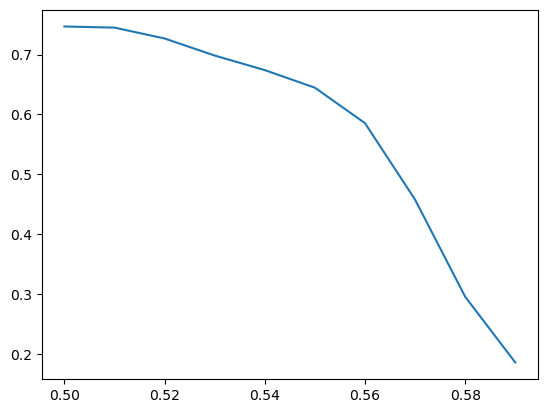

In [91]:
metric.graph_metric("f1-score")

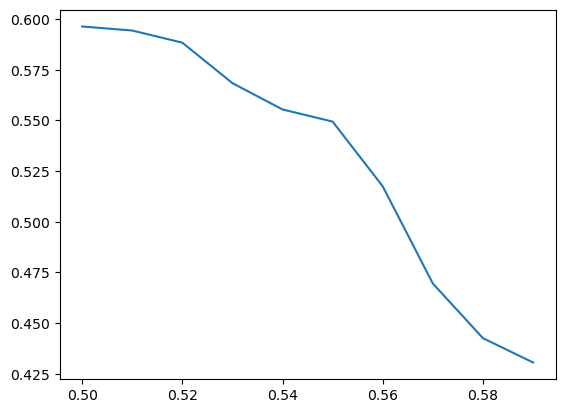

In [92]:
metric.graph_metric("accuracy")

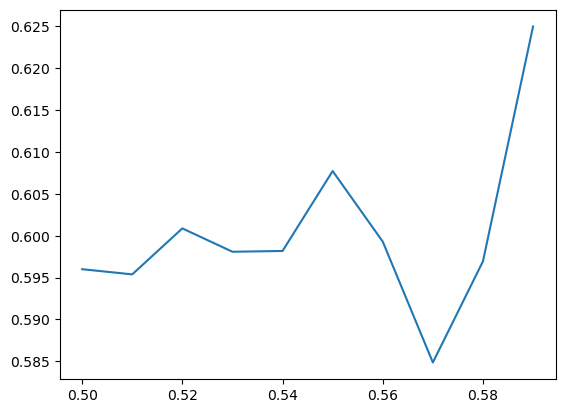

In [93]:
metric.graph_metric("precision")

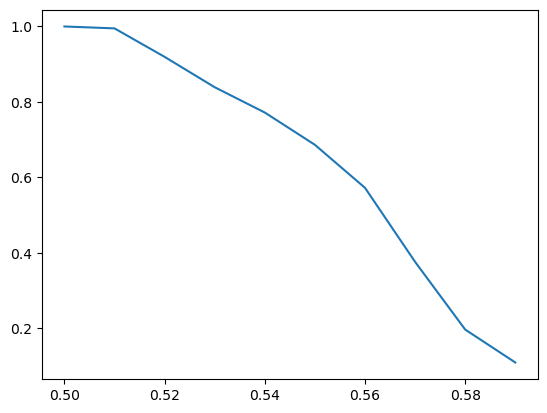

In [94]:
metric.graph_metric("recall")